# Import dependencies

In [254]:
#!pip install Pillow

In [7]:
#!pip install keyboard

     ---------------------------------------- 58.1/58.1 kB 1.5 MB/s eta 0:00:00


In [2]:
!tar -xf AnimalFace.zip

In [3]:
# filepath/utils
import os
import keyboard
from IPython.display import clear_output
#used to convert image data
import numpy as np
from numpy import asarray
from matplotlib import pyplot as plt
#Save and load svm model
from joblib import dump
from joblib import load
import joblib
#used to find the file extensions
import glob
#used to handle images
import PIL
from PIL import Image

#Used to create the test/validation partitions on the dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#Used to encode the labels  
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#TF and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
#svm
from sklearn import svm

# EDA

# Visualize the structure of the dataset

In [4]:
os.listdir('Image')

['BearHead',
 'CatHead',
 'ChickenHead',
 'CowHead',
 'DeerHead',
 'DogHead',
 'DuckHead',
 'EagleHead',
 'ElephantHead',
 'HumanHead',
 'LionHead',
 'MonkeyHead',
 'MouseHead',
 'Natural',
 'PandaHead',
 'PigeonHead',
 'PigHead',
 'RabbitHead',
 'SheepHead',
 'TigerHead',
 'WolfHead']

In [5]:
folders = os.listdir('Image')

### Visualize how many images are present for each class

In [6]:
for folder in folders:
   print(folder, len(os.listdir('Image/'+folder)) )

BearHead 101
CatHead 160
ChickenHead 100
CowHead 104
DeerHead 103
DogHead 389
DuckHead 103
EagleHead 101
ElephantHead 100
HumanHead 100
LionHead 102
MonkeyHead 100
MouseHead 100
Natural 8
PandaHead 119
PigeonHead 115
PigHead 101
RabbitHead 100
SheepHead 100
TigerHead 114
WolfHead 100


# Visualize the file format
### the objective here is to verify if all files are in the same format

In [7]:
extensions = []
for folder in folders:
    for file_name in os.listdir('Image/'+folder):
         _, file_extension = os.path.splitext(file_name)
         extensions.append(file_extension)

In [8]:
len(extensions)

2420

In [9]:
extension_counts = {}
for extension in extensions:
    extension_counts[extension] = extension_counts.get(extension, 0) + 1  

In [10]:
# Extract extensions and counts for plotting
labels = list(extension_counts.keys())
counts = list(extension_counts.values())

## Here is a visualization of the file extensions and we can observe that some files are saved in different formats
### at this stage I will have to research on whether file extensions are case sensitive or not, It will also be necessary to verify if the gif images contains animations or transparency.

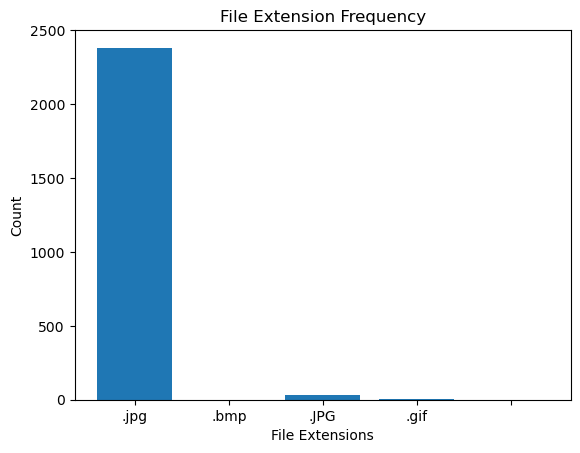

In [11]:
plt.bar(labels, counts)
plt.xlabel('File Extensions')
plt.ylabel('Count')
plt.title('File Extension Frequency')
plt.show()

# Logic to find file extensions

### Here I'm defining a method that will find files with an especific extension and the method will return the filepath

In [12]:
def find_files_with_extension(folder_path, extension):
    search_pattern = os.path.join(folder_path, f"*.{extension}")
    file_paths = glob.glob(search_pattern)
    
    return file_paths

### Looping through all folders to find files with 'gif' extension, as only two files were found I manually checked if the files contains animations or transparency which was not the case, at this stage I believe that these files can be converted in the future with no problems.

In [13]:
extension = 'gif'
for folder in folders:
    gif_files = find_files_with_extension('Image/'+folder, extension)
    for file_path in gif_files:
        print(file_path)

Image/CowHead\cow1.gif
Image/TigerHead\tiger-tatiana.gif


# In this section I will make analysis on the dimension of the images, the reason that I am making these analysis is explained below

### saving all images into an array

In [14]:
images = []
for folder in folders:
    for file_name in os.listdir('Image/'+folder):
         image = Image.open('Image/'+folder+'/'+file_name)
         images.append(image)

### extracting the dimension of each image and counting to verify frequency

In [15]:
dimensions = []
for image in images:
    dimensions.append(image.size)

In [16]:
dimension_counts = {}
for dimension in dimensions:
    dimension_counts[dimension] = dimension_counts.get(dimension, 0) + 1  
    

In [17]:
dimensions = [str(dim) for dim in dimension_counts.keys()]
counts = list(dimension_counts.values())

### Here is where I try to make some visualizations in order to check the frequency of the dimensions of the images in the dataset, that will assist me to decide on how to pre-process the images in the future, as you can see the dimensions are all over the place =(, it was hard to even plot to make some sense out of these values, the best visualization I could use was the PIE plot, in the PIE plot we can observe that 48% of the images have 150x150 pixels dimension

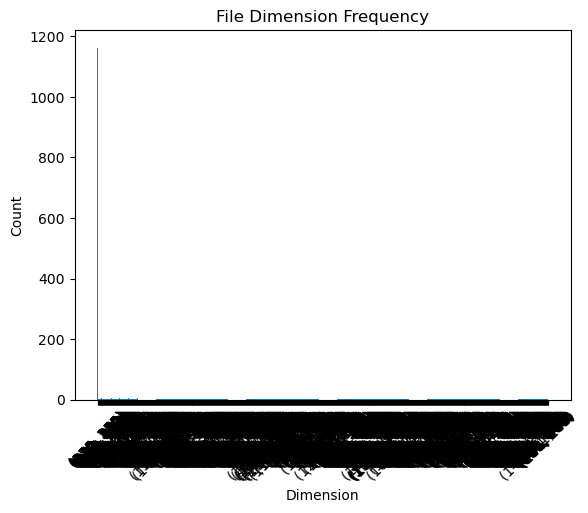

In [18]:
plt.bar(dimensions, counts)
plt.xlabel('Dimension')
plt.ylabel('Count')
plt.title('File Dimension Frequency')
plt.xticks(rotation=45)
plt.show()

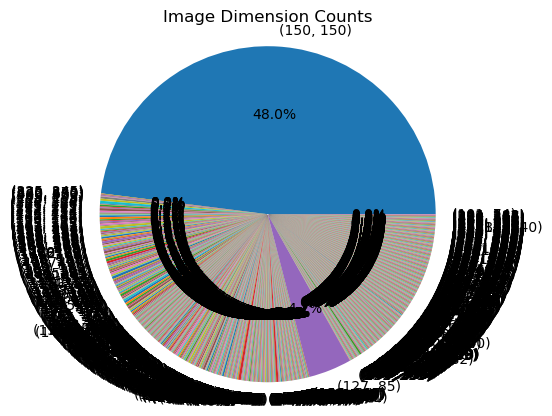

In [19]:
plt.pie(counts, labels=dimensions, autopct='%1.1f%%')
plt.title('Image Dimension Counts')
plt.axis('equal')
plt.show()

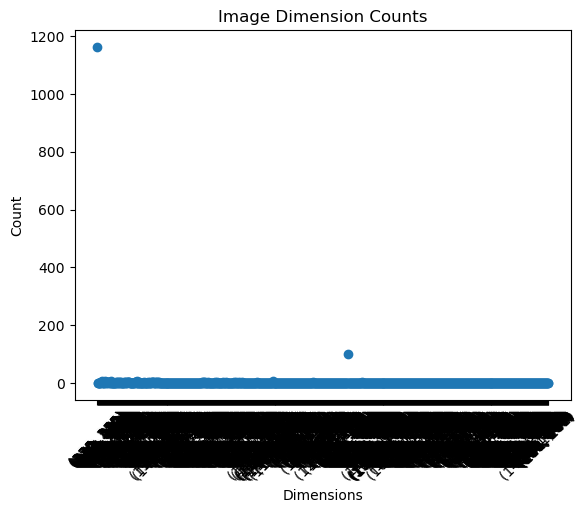

In [20]:
plt.scatter(dimensions, counts)
plt.xlabel('Dimensions')
plt.ylabel('Count')
plt.title('Image Dimension Counts')
plt.xticks(rotation=45)
plt.show()

### Here I am trying to verify what are the minimum and maximum dimensions, that would help me to understand the impact that resizing the images would have on the data.

In [21]:
# Extract dimensions for analysis
dimensions = list(dimension_counts.keys())

# Get min and max dimensions
min_dimension = min(dimensions)
max_dimension = max(dimensions)

print("Minimum Dimension:", min_dimension)
print("Maximum Dimension:", max_dimension)


Minimum Dimension: (30, 26)
Maximum Dimension: (1775, 2529)


### Another option would be to calculate the average dimension, but I do not think that would work, My approach will be trying to preserve the data with a higher volume. At this point I believe that I can conclude that resizing the images to 150x150 pixels would be my best option, that would keep 48% of the data intact, cause minor distortion on part of the data and cause a possible disruptive distortion on a small sample of the data.

In [22]:
# Calculate average dimension
total_dimensions = len(dimensions)
sum_width = sum(dim[0] for dim in dimensions)
sum_height = sum(dim[1] for dim in dimensions)
average_width = sum_width / total_dimensions
average_height = sum_height / total_dimensions

average_dimension = (average_width, average_height)
print("Average Dimension:", average_dimension)

Average Dimension: (277.32194046306506, 276.40683572216096)


# Another visual example on the data

In [23]:
print("Dimension Counts:")
for dimension, count in dimension_counts.items():
    print(f"Dimension: {dimension} | Count: {count}")

Dimension Counts:
Dimension: (150, 150) | Count: 1162
Dimension: (325, 345) | Count: 1
Dimension: (272, 252) | Count: 1
Dimension: (520, 570) | Count: 1
Dimension: (640, 480) | Count: 2
Dimension: (480, 552) | Count: 1
Dimension: (800, 600) | Count: 1
Dimension: (263, 263) | Count: 5
Dimension: (123, 123) | Count: 5
Dimension: (204, 204) | Count: 6
Dimension: (378, 378) | Count: 2
Dimension: (387, 386) | Count: 1
Dimension: (105, 105) | Count: 4
Dimension: (141, 141) | Count: 2
Dimension: (215, 215) | Count: 2
Dimension: (287, 287) | Count: 6
Dimension: (134, 134) | Count: 4
Dimension: (154, 154) | Count: 3
Dimension: (411, 411) | Count: 2
Dimension: (243, 243) | Count: 2
Dimension: (168, 168) | Count: 4
Dimension: (169, 169) | Count: 5
Dimension: (139, 139) | Count: 3
Dimension: (233, 233) | Count: 2
Dimension: (177, 177) | Count: 3
Dimension: (165, 165) | Count: 2
Dimension: (242, 242) | Count: 4
Dimension: (301, 301) | Count: 2
Dimension: (236, 236) | Count: 6
Dimension: (187, 187) 

# Data Preparation

## Standardize files format
### Previous analysis on the data set showed that we have different file formats such as jpg and gif, I learnt during my research that PNG format would be a strong candidate for this project, the reason I am converting the images to the PNG format is because of its Lossless Compression and Lossless editing properties

## Resize images
### Resizing the images is crucial for this project, models will not work if you feed images with different sizes, also reducing the image sizes will reduce the amount of data to be processed consequently reducing the computational power.
## Normalize images
### Normalization is important because of the mathematical operations performed by the models

### This cell will convert the images from the dataset to .png format and resize them for 150x150 pixels, The reason I did this was to standardize the dataset, the rationale behind the values was explained previously.

In [24]:
def preprocess():
    # Create the destination directory if it doesn't exist
    if not os.path.exists('pp_images'):
        os.makedirs('pp_images')
    for folder in folders:
        if not os.path.exists('pp_images/' + folder):
            os.makedirs('pp_images/' + folder)
        for file_name in os.listdir('Image/' + folder):
            image = Image.open('Image/' + folder + '/' + file_name)
            
            # Construct the new file path by joining the destination directory path and the file name
            new_file_path = os.path.join('pp_images/' + folder, file_name[:len(file_name)-4] + ".png")
            image = image.resize((150,150))
            
            
            # Save the image with the new file path and PNG format
            image.save(new_file_path, format='PNG')
            
                        
    print("File processing completed.")

In [25]:
preprocess()

File processing completed.


## In this section I am testing the results of the image processing method and I am also checking for possibilities to convert the image data to numpy array, the reason I am doing this is because my first Model will be based on Neural networks using Keras.

In [26]:
img = Image.open('pp_images/BearHead/bearfrontal0001.png')

In [27]:
data = asarray(img)

In [28]:
data.shape

(150, 150, 3)

In [29]:
folderlist = os.listdir('pp_images')

## This loop creates the dataset, I excluded the 'Natural' folder as it does not contain valid data for this project, Here I am also finishing the preprocessing, I am ensuring that all image files are in 3 channels (RGB), the reason for that is because some files are in grayscale and that will result in different data shapes which will not be accepted by the model, I am also converting each image to a numpyarray format so I can apply normalization to the pixel values, Each pixel value naturaly ranges from 0 to 255, by dividing those values by 255 We will end with values ranging from 0 to 1 which helps to standardize the input data, improve training stability, enhance model generalization and ensure compatibility with specific models or activation functions.
## Previously I observed the number of images for each class, based on those observations I decided to extract 100 images for each class, by doing that I will have the exact same amount of samples for each class, making the data well balanced for the training steps, which will result in a model that can generalize well, reducing the bias will make the model to classify better images that it has not seen before, it also helps to avoid overfitting the model.

In [30]:
images = []
labels = []
testimg = []
i=0
for folder in folderlist:
    if(folder!='Natural'):
        print(folder)
        for file_name in os.listdir('pp_images/'+folder):

            image = Image.open('pp_images/'+ folder +'/'+file_name).convert('RGB')
            image = asarray(image)
            image = image.astype(np.float32) / 255.0
           
          


            images.append(image)
            labels.append(folder)
            if(i==99):
                i=0;
                break
            i = i+1;
            
# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)
# Encode the labels as numeric values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


BearHead
CatHead
ChickenHead
CowHead
DeerHead
DogHead
DuckHead
EagleHead
ElephantHead
HumanHead
LionHead
MonkeyHead
MouseHead
PandaHead
PigeonHead
PigHead
RabbitHead
SheepHead
TigerHead
WolfHead


### The cell below have the class names that will 'decode' the label returned by the model when predicting, I did it manually but during the development I have learnt that there is a way to decode using a different method =D

In [31]:
class_names = ['BearHead','CatHead','ChickenHead','CowHead','DeerHead','DogHead','DuckHead','EagleHead','ElephantHead','HumanHead','LionHead','MonkeyHead','MouseHead','PandaHead','PigeonHead','PigHead','RabbitHead','SheepHead','TigerHead','WolfHead']
    

### Splitting the dataset, I tried training the model using different ratios 60/40, 70/30 and 80/20, the ratio of 80/20 have achieved better results

In [32]:
# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

#### here I was just checking if the train set and the labels were matching the expected values

18

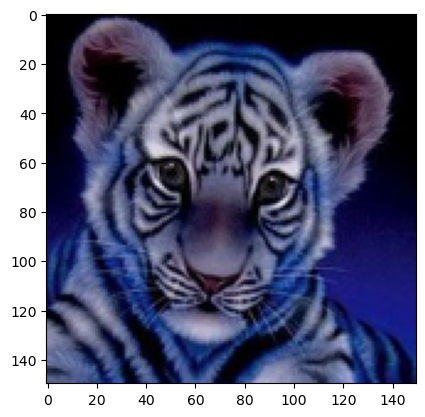

In [33]:
plt.imshow(train_images[25])
train_labels[25]

### This was my starting point, I have trained the model with this archtecture and the results where not very good, I have tried to find the maths behind the number of layers and the kernel size, still could not find nothing that will make me understand or have a reason for choosing those values, so I went for a try and error approach.

In [34]:
# Create a sequential model
model = models.Sequential()

#convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(20, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### After MANY hours trying different values for each layer and spending MANY HOURS waiting the model training with those new hyperparameters, I have found a similar project on the tensorflow website, from that project I 'borrowed' the values for the layers, I also learnt about this new layer that until now it was new to me, the Dropout layer, which will drop some neurons improving the model's learning curve, this will force the model to learn more robust representation of the data and consequently help to avoid overfitting the model, overfitting the model was a big challenge considering that there are only 100 images for each class, I believe that I could apply data augmentation to improve the model, but I am running out of time, so please consider the fact that I am aware of this possibility =D. There was a noticeble difference when I changed the first Dense layer hyperparameter to 512, it brought a huge improvement and I can not explain why.
### Comparing the archtecture that I was using with the one from tensorflow I could notice that it was possible to add one more convolutional layer to the archtecture, I research on why  the archtecture would have two identical convolutional layers at the end and I could not find an exact answer, but I do believe it could be something related to a RNN archtecture. By adding this identical layer at the end also improved the model accuracy.

### Another change made when I was tunning the model was changing the optimizer, The 'rmsprop' showed better results compared to 'adam'

### Back to the layers, I know and I understand the purpose of each layer, but when I tried different values in the hyperparameters the results sometimes were really bad e.g(0.03 accuracy)
### Not understanding the Maths behind the hyperparameters of the convolutional layers was a real problem in this project, I am quite sure there is a way to calculate those values to at least have some range of optimal values based on the size of the image or how precise is the feature extraction that you want to perform.
### In theory increasing the kernel size in the convolutional layers would sharpen the patterns during the feature extraction, So I tried a combination of Lower values in the first layers to reduce the data in the image and extract more generic patterns then use higher values in the following layers to extract a better/sharper pattern for each class, The reason I was trying to get better patterns is because some animals have similar characteristics e.g(Wolf / Dog, Birds Pigeon/Chicken/Duck ), but not knowing EXACTLY what each layer is doing  and how to specificly tune a layer and verify the results for that change is what makes it so hard to classify accurately the classes for this project.

### Another problem in this project was the quality of data, I had to Manually check the images to figure out why I could not classify some animals and I found out it was related to the images present in the dataset, In this project we are working with Animal Heads, but some pictures contains the animal full body and the background, in other cases there are not enough angles so the model could not generalize very well , for example, some animals only had close up images in a front view, elephant images where all over the place with different zoom levels, different background etc, so when I was attempting to predict with the model using images that the model have not seen before It could not predict correctly, I will use the elephant case as an example, I Downloaded some pictures of Elephant Heads and tried to predict, the model could not predict correctly, than I tried a different picture where the image contain an Elephant (whole body) and the model was able to predict correctly, I could conclude that the problem was not only related on the small amount of data present, the model archtecture or the training process but also the quality of the data.


In [35]:
# Create a sequential model
model = models.Sequential()

#Convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from the previous layer
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

# Add a dense (fully connected) layer
model.add(layers.Dense(512, activation='relu'))

# Add an output layer with softmax activation for classification
model.add(layers.Dense(20, activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [503]:
model.fit(train_images,train_labels,epochs=25, validation_data=(test_images,test_labels))

Epoch 1/25
50/50 [==============================] - 24s 485ms/step - loss: 0.1767 - accuracy: 0.9438 - val_loss: 2.0164 - val_accuracy: 0.6400
Epoch 2/25
50/50 [==============================] - 24s 474ms/step - loss: 0.1671 - accuracy: 0.9438 - val_loss: 1.7896 - val_accuracy: 0.6875
Epoch 3/25
50/50 [==============================] - 23s 456ms/step - loss: 0.1369 - accuracy: 0.9600 - val_loss: 1.4818 - val_accuracy: 0.7375
Epoch 4/25
50/50 [==============================] - 23s 458ms/step - loss: 0.1449 - accuracy: 0.9588 - val_loss: 1.4134 - val_accuracy: 0.7600
Epoch 5/25
50/50 [==============================] - 23s 458ms/step - loss: 0.1286 - accuracy: 0.9638 - val_loss: 1.4523 - val_accuracy: 0.7300
Epoch 6/25
50/50 [==============================] - 23s 456ms/step - loss: 0.1074 - accuracy: 0.9706 - val_loss: 2.5344 - val_accuracy: 0.6500
Epoch 7/25
50/50 [==============================] - 23s 460ms/step - loss: 0.0566 - accuracy: 0.9825 - val_loss: 1.7655 - val_accuracy: 0.7425

### Evaluating the model I could conclude that the model is capable of predict fairly well with images that is has not seen before with some limitations that were explained above, but there is still place for improvements, I could get the model to train through 25 epochs, If I increase the epochs at this stage it would overfit the model, yet the loss value for the validation set still could be improved if I could increase the number of epochs, but to achieve that, the solution would be augmenting the data with synthetic data, The only reason I am not demonstrating it is because I do not have enough time to try the implementation which would require retraining the model and fine tuning it again.

In [38]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Print the test loss and accuracy
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

13/13 [==============================] - 2s 113ms/step - loss: 2.8540 - accuracy: 0.7175
Test Loss: 2.8540291786193848
Test Accuracy: 0.7174999713897705


### Saving / Loading the model

In [506]:
model.save('most_accurate.h5')

In [37]:
model = tf.keras.models.load_model('most_accurate.h5')

### Preprocess image 

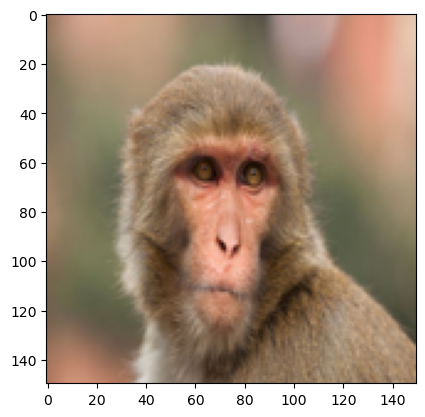

In [40]:
imagetest = Image.open('download/monkey2.png').convert('RGB')
imagetest = imagetest.resize((150,150))
imagetest = asarray(imagetest)
imagetest = imagetest.astype(np.float32) / 255.0
plt.imshow(imagetest)

In [41]:
imagetest.shape

(150, 150, 3)

### Predict with images that the model has not seen before

In [42]:
prediction = model.predict(np.array([imagetest]))
index = np.argmax(prediction)
print(f'prediction is {class_names[index]}')

1/1 [==============================] - 0s 95ms/step
prediction is MonkeyHead


# Testing the model across all classes

## I downloaded 3 random images from the internet for each class to test the model
## Press N to go to the next image, double tap 'i' key to interrupt the kernel

### the cell below is just a shortcut in case the kernel is restarted, run the dependencies cell and you can jump back to this point, load the class 'decoder' and load the model

In [43]:
class_names = ['BearHead','CatHead','ChickenHead','CowHead','DeerHead','DogHead','DuckHead','EagleHead','ElephantHead','HumanHead','LionHead','MonkeyHead','MouseHead','PandaHead','PigeonHead','PigHead','RabbitHead','SheepHead','TigerHead','WolfHead']
model = tf.keras.models.load_model('most_accurate.h5')

In [44]:
# Specify the directory path
directory = 'download'

# Get a list of files in the directory
file_list = os.listdir(directory)

# Initialize an index to keep track of the current file
current_file_index = 0

# Loop through the files
while current_file_index < len(file_list):
    # Get the current file name
    file_name = file_list[current_file_index]
    
    # Load and process the image
    imagetest = Image.open(os.path.join(directory, file_name)).convert('RGB')
    imagetest = imagetest.resize((150, 150))
    imagetest = np.asarray(imagetest).astype(np.float32) / 255.0
    
    # Display the image
    plt.imshow(imagetest)
    plt.show()
    # predict
    prediction = model.predict(np.array([imagetest]))
    index = np.argmax(prediction)
    print(f'prediction is {class_names[index]}')
      
 
    
    # Wait for key press to load the next file
    while not keyboard.is_pressed('n'):
        pass
    # Clear the output of the current cell
    clear_output(wait=True)
    # Increment the index to move to the next file
    current_file_index += 1

print("All files processed.")

All files processed.


# Supervised Vector Machine classifier

### To train this model it was necessary to reshape the data to a 1D array, by training the model without fine tunning it, an accuracy of 54% was achieved, I chose this classifier as it can perform well for image classification tasks, Compared to a sequential model (CNN/RNN) it performed surprisingly well, The model I am comparing started with an Accuracy of about 62% percent before tunning, I can conclude that with some adjustments the Supervised Vection machine classifier can achieve results close to the sequential models. It was a bit hard to get the model to predict correctly with images it have not seen before, at least I managed to get the model to a point where is possible to see that with some improvements it is possible to use SVM for image recognition tasks. Applying feature scaling techniques had a huge impact on the model ability to predict more precisely.

In [123]:
# Reshape the images to flatten them
num_samples, height, width, channels = train_images.shape
train_images_reshaped = train_images.reshape(num_samples, height * width * channels)

# Feature scaling 
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images_reshaped)


# Create an SVM classifier
svm_classifier = svm.SVC()

# Fit the SVM model to the training data
svm_classifier.fit(train_images_scaled, train_labels)

SVC()

### Saving/loading the model

In [140]:
dump(svm_classifier, 'svm_model_v5.joblib')

['svm_model_v5.joblib']

In [135]:
np.save('label_encoder_classes_v5.npy', label_encoder.classes_)

In [136]:
# Save the scaler to a file
joblib.dump(scaler, 'scaler_v5.pkl')

['scaler_v5.pkl']

In [46]:
# Load the SVM model from file
svm_classifier = load('svm_model_v5.joblib')
label_encoder.classes_ = np.load('label_encoder_classes_v5.npy')
scaler = joblib.load('scaler_v5.pkl')

### Evaluation

In [47]:
# Reshape the test images
num_samples_test, height_test, width_test, channels_test = test_images.shape
test_images_reshaped = test_images.reshape(num_samples_test, height_test * width_test * channels_test)
test_images_scaled = scaler.transform(test_images_reshaped)


# Predict the labels for the test images
predicted_labels = svm_classifier.predict(test_images_scaled)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.5325


### Load Preprocess test image

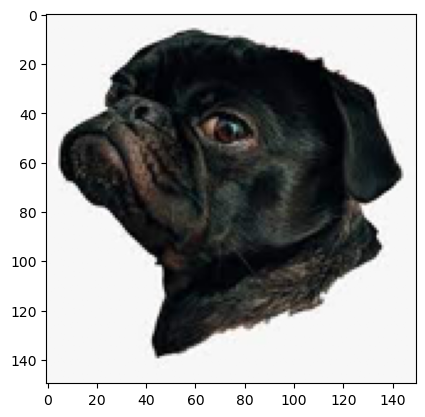

In [48]:
imagetest = Image.open('download/dog2.png').convert('RGB')
imagetest = imagetest.resize((150,150))
imagetest = asarray(imagetest)
imagetest = imagetest.astype(np.float32) / 255.0


# Reshape the image
height, width, channels = imagetest.shape
image_reshaped = imagetest.reshape(1, height * width * channels)

# Scale the image data using the fitted StandardScaler
image_scaled = scaler.transform(image_reshaped)
plt.imshow(imagetest)

### Predict

In [49]:
# Predict the label of the image
predicted_label_encoded = svm_classifier.predict(image_scaled)
predicted_label_int = predicted_label_encoded[0]

# Convert the predicted label back to the original label
predicted_label = label_encoder.inverse_transform([predicted_label_int])

# Print the predicted label
print(f'Predicted label: {predicted_label}')

Predicted label: ['DogHead']


# Test the SVM model with samples downloaded from the internet for all classes

## Press 'N' to load the next image
## Double tap 'i' to interrupt

In [50]:
#scaler = StandardScaler()
# Specify the directory path
directory = 'download'

# Get a list of files in the directory
file_list = os.listdir(directory)

# Initialize an index to keep track of the current file
current_file_index = 0

# Loop through the files
while current_file_index < len(file_list):
    # Get the current file name
    file_name = file_list[current_file_index]
    
    # Load and process the image
    imagetest = Image.open(os.path.join(directory, file_name)).convert('RGB')
    imagetest = imagetest.resize((150, 150))
    imagetest = np.asarray(imagetest).astype(np.float32) / 255.0
    # Reshape the image
    height, width, channels = imagetest.shape
    image_reshaped = imagetest.reshape(1, height * width * channels)

    # Scale the image data using the fitted StandardScaler
    image_scaled = scaler.transform(image_reshaped)
    plt.imshow(imagetest)
    
        
    # Display the image
    plt.imshow(imagetest)
    plt.show()
    # Predict the label of the image
    predicted_label_encoded = svm_classifier.predict(image_scaled)
    predicted_label_int = predicted_label_encoded[0]

    # Convert the predicted label back to the original label
    predicted_label = label_encoder.inverse_transform([predicted_label_int])

    # Print the predicted label
    print(f'Predicted label: {predicted_label}')
      
 
    
    # Wait for key press to load the next file
    while not keyboard.is_pressed('n'):
        pass
    # Clear the output of the current cell
    clear_output(wait=True)
    # Increment the index to move to the next file
    current_file_index += 1

print("All files processed.")

All files processed.


# Attempt to fine tune the model

### Here I performed a gridsearch trying to find the optimal values for the 'c' and 'gamma' hyperparameters, this attempt literally took about 3 hours and the results were a disaster

In [160]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}

# Perform grid search cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new SVM model with the best hyperparameters
svm_classifier_tuned = svm.SVC(**best_params)

# Train the tuned SVM model
svm_classifier_tuned.fit(X_train_scaled, y_train)

# Predict the labels for the test images
predicted_labels_tuned = svm_classifier_tuned.predict(X_test_scaled)

# Calculate accuracy with tuned model
accuracy_tuned = accuracy_score(y_test, predicted_labels_tuned)

# Print the accuracy with tuned model
print("Tuned Accuracy:", accuracy_tuned)

Tuned Accuracy: 0.0375


### Again I am struggling to achieve results while fine tunning a model, this time I tried the 'try error' approach, I research on some hyperparameters of the svc model and I learnt about 'C' , 'gamma' and the 'max_iter':
### C is the regularization parameter (also known as the penalty parameter) in SVM. It controls the trade-off between achieving a low training error and having a simple decision boundary. Smaller values of C lead to a wider margin but potentially more misclassifications, while larger values of C result in a narrower margin but potentially overfitting to the training data.

### gamma is the kernel coefficient in SVM. It defines the influence of each training example on the decision boundary. A low value of gamma means that the decision boundary is influenced by a broader range of training examples, while a high value of gamma means that the decision boundary is influenced by only nearby training examples.

### max_iter controls how many times the training process will iterate through the dataset

### Researching on these hyperparameters I learnt some values that are commonly used: 0.1, 1 and 10 so I tried all possible combinations of those values with different max iterations, there is an option on the max iteration, if you set it to '-1' it will stop before convergence occurs, yet after all these attempts I could not find a way to improve the model, by manually changing the hyperparameters the best result achieved while evaluating the model was about 13% accuracy.

In [248]:
# Reshape the images to flatten them
num_samples, height, width, channels = train_images.shape
train_images_reshaped = train_images.reshape(num_samples, height * width * channels)

# Create an SVM classifier
svm_classifier_t = svm.SVC(C=1, gamma=1, max_iter=1500)

# Train the SVM model
svm_classifier_t.fit(train_images_reshaped, train_labels)
    
   

SVC(C=1, gamma=1, max_iter=1500)

In [249]:
# Reshape the test images
num_samples_test, height_test, width_test, channels_test = test_images.shape
test_images_reshaped = test_images.reshape(num_samples_test, height_test * width_test * channels_test)

# Predict the labels for the test images
predicted_labels = svm_classifier_t.predict(test_images_reshaped)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.04
